Implementation of 2D finite difference, solve the equation using weighted Jacobi iteration method.

Construct the linear equation system Ax = b for a 2D Poisson problem:
            - u_xx - u_yy = f(x,y), -1 < x,y < 1

Under pure periodic boundary conditions

Arrange the rhs indices as:

f_00, f_01, f_02, ..., f0N, f1N, f2N, ...

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class GridFD():
    '''
    Note: the n should be the number of intervals, e.g., 
    there are (n+1)*(n+1) grid points if the size is n
    '''
    def __init__(self, n, rhs = None):
        self.n = n
        self.v = np.zeros((n+1)*(n+1))
        if (rhs is None):
            self.f = np.zeros((n+1)*(n+1))
        else:
            self.f = np.copy(rhs)        
        self.A = self.CreateA()
        
    def CreateA(self):
        '''
        Construct the matrix based on row-index first rule, assume a square domain: hx = hy = h
        Note this matrix is used for periodic boundary conditions
        ''' 
        h = 2.0/self.n
        stencil = np.array([-1.0/h/h, 4.0/h/h, -1.0/h/h])
        B_temp = np.zeros((self.n+3,self.n+3))
        for i in range(1,self.n+2):
            B_temp[i,i-1:i+2] = stencil
        B = B_temp[1:self.n+2,1:self.n+2] # size is (n+1)x(n+1)
        B[0,self.n-1] = -1.0/h/h # modify for periodic boundaries at i = :, j = 0 
        B[self.n-1, 0] = -1.0/h/h # modify for periodic boundaries at i = :, j = N-1
        A = np.kron(np.eye(self.n+1),B) # diagonal of the stiffness matrix

        Eye_side_block = -1./h/h*np.eye(self.n+1) # size is (n+1)x(n+1)
        A = A + np.kron(np.diag(np.ones(self.n),1),Eye_side_block)
        A = A + np.kron(np.diag(np.ones(self.n),-1),Eye_side_block)

        idx = np.arange(self.n+1)
        idy = idx + (self.n+1)*(self.n-1) 
        A[idx,idy] = -1.0/h/h # modify for periodic boundaries at i = 0, j = :
        A[idy,idx] = -1.0/h/h # modify for periodic boundaries at i = N-1, j = :

        # assure u_Nj = u_0j
        idy = idx + (self.n+1)*self.n # index of i = N
        A[idy,:] = 0.0
        A[:,idy] = 0.0
        A[idy,idy] = 1.0
        A[idy,idx] = -1.0
        self.f[idy] = 0.0

        # assure u_iN = ui0
        idy = np.arange(self.n, (self.n+1)*(self.n+1), self.n+1)
        A[idy,:] = 0.0
        A[:,idy] = 0.0
        A[idy,idy] = 1.0
        A[idy,idy-self.n] = -1.0
        self.f[idy] = 0.0

        return A

    def Relax(self, num_sweeps_down):
        '''
        Perform a fixed number of weighted Jacobi iterations for current level of grid
        '''
        omega = 2/3.
        Dinv = np.diag(1.0/np.diag(self.A))
        v = self.v
        for i in range(num_sweeps_down):
            vprev = v
            residual = self.f - np.dot(self.A,vprev)
            v = omega*np.dot(Dinv,residual) + vprev
        return v

In [12]:
# Problem parameters
n = 2**5

x = np.linspace(-1,1,n+1)
y = np.linspace(-1,1,n+1)
xx, yy = np.meshgrid(x, y, indexing='ij')

rhs = np.sin(1.*np.pi*(xx+0.5))*np.cos(0.*np.pi*(yy))
prob = GridFD(n, rhs.flatten())

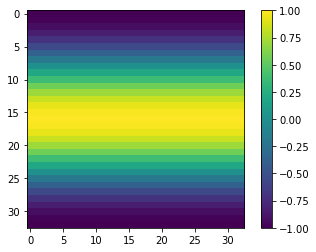

In [13]:
'''Plot the rhs vector v in 2D'''
rhs_f = rhs.reshape(xx.shape)
plt.imshow(rhs_f)
plt.colorbar()

In [14]:
EPS = 1e-6
n_jacobi = 0
u_jacobi = np.zeros((n+1)*(n+1))
res = np.linalg.norm(prob.f - np.dot(prob.A,u_jacobi))
res_jacobi = [res]
while (res>EPS):
    prob.v = u_jacobi
    u_jacobi = prob.Relax(1)
    res = np.linalg.norm(prob.f - np.dot(prob.A,u_jacobi))
    res_jacobi.append(res)
    n_jacobi += 1
    print(n_jacobi, res)

print("Solution converges after ", n_jacobi, "Weighted Jacobi iterations")

1 22.482490959495504
2 22.338493062744927
3 22.195417250052436
4 22.0532577314578
5 21.912008696229734
6 21.771664335325227
7 21.632218862537567
8 21.493666523442645
9 21.356001598601765
10 21.219218404555363
11 21.083311294019406
12 20.948274655801995
13 20.8141029146234
14 20.68079053090379
15 20.548332000540633
16 20.416721854683544
17 20.28595465950926
18 20.156025015997542
19 20.02692755970826
20 19.898656960560054
21 19.771207922610234
22 19.6445751838361
23 19.518753515917744
24 19.39373772402214
25 19.269522646588683
26 19.14610315511609
27 19.023474153950623
28 18.90163058007577
29 18.78056740290314
30 18.660279624064795
31 18.5407622772069
32 18.4220104277846
33 18.304019172858393
34 18.186783640891598
35 18.070298991549326
36 17.95456041549852
37 17.839563134209474
38 17.72530239975859
39 17.611773494632146
40 17.49897173153175
41 17.386892453180685
42 17.275531032131685
43 17.16488287057577
44 17.054943400152624
45 16.945708081761715
46 16.837172405375114
47 16.729331889851

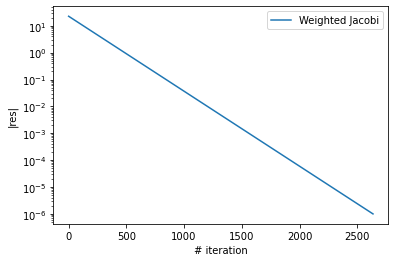

In [15]:
# Plot the residual evolution
plt.plot(res_jacobi, label='Weighted Jacobi')
#plt.xscale('log')
plt.yscale('log')
plt.xlabel('# iteration')
plt.ylabel('|res|')
plt.legend()

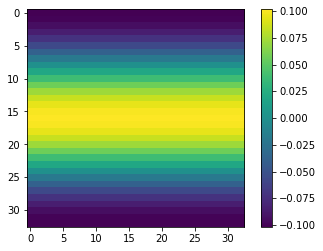

In [16]:
'''Plot the solution vector v in 2D'''
solution = prob.v
uu = solution.reshape(xx.shape)
plt.imshow(uu)
plt.colorbar()

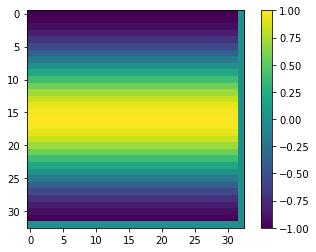

In [17]:
initial_f = prob.f.reshape(xx.shape)
plt.imshow(initial_f)
plt.colorbar()

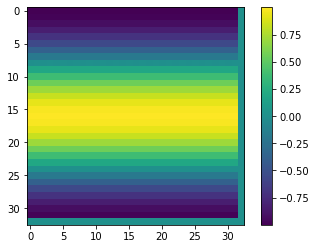

In [18]:
final_f = np.dot(prob.A,prob.v)
final_f = final_f.reshape(xx.shape)
plt.imshow(final_f)
plt.colorbar()